# $H \rightarrow ZZ \rightarrow 4\ell$ Classification with an FNN
 >__Created__:  May 2022 INFN School of Statistics, Paestum, Italy<br>
 > __Updated__: March 19, 2023 for CLASHEP 2023, San Esteban, Chile<br>
 > __Updated__: June 28, 2023 for Terascale 2023, DESY, Hamburg, Germany
 
 
## Task
Use a feed-forward neural network (FNN) to discriminate between Higgs boson events produced via vector boson fusion from events produced via gluon gluon fusion using the di-jet mass $m_{jj}$ (massjj) and the di-jet separation $|\Delta\eta_{jj}|$ (detajj) in pseudorapidity. 

## Introduction
In this notebook, we build a machine learning model (a simple feed-forward neural network) to discriminate between two classes of events, $H \rightarrow ZZ \rightarrow 4\ell$ produced via vector-boson fusion (__vbf__) and the same final state produced via gluon-gluon fusion (__ggf__). We use __supervised learning__ in which the data instances $\boldsymbol{x}$ that characterize the objects to be classified, here Higgs boson events,  are unambiguously labeled by the class to which the instances belong. The class labels $t$ are referred to as __targets__. 

The data are read from __csv__ files, each row of which contains quantities that characterize $H \rightarrow ZZ \rightarrow 4\ell$ events. In __machine learning__, these quantities are often referred to as __features__ and form __feature vectors__. We use the following features $\boldsymbol{x} \equiv (|\Delta\eta_{jj}|, m_{jj})$ where $|\Delta\eta_{jj}|$ is the di-jet absolute pseudorapidiy difference (detajj) and $m_{jj}$ the di-jet mass (massjj). 
 
The fundamental assumption of almost all machine learning models is that the data are a sample from a joint probability distribution $p(t, \mathbf{x}) dt d\mathbf{x}$, which is generally unknown. 

We shall use the model 

$$f(\boldsymbol{x}, \boldsymbol{\omega}) = \text{sigmoid}(\, b_3 + \boldsymbol{w}_3\text{relu}(\, \boldsymbol{b}_2 + \boldsymbol{w}_2 \, \text{relu}(\,\boldsymbol{b}_1 + \boldsymbol{w}_1 \, \text{relu}(\boldsymbol{b}_0 + \boldsymbol{w}_0 \, \boldsymbol{x}) \, )\,)\,),$$

where $\boldsymbol{b}$ and $\boldsymbol{w}$ (the biases and weights) are the parameters $\boldsymbol{\omega}$ of the model and $\mbox{relu}(x)$ is a non-linear function defined by
\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise} ,
\end{cases}
\end{align*}
applied to every element $x_i$ of its argument (i.e., applied element-wise). 

The functions $\mbox{sigmoid}(x)$ and $\mbox{relu}(x)$ are implemented in the PyTorch functions
torch.sigmoid(...) and torch.relu(...), respectively, as well as in torch.nn.Sigmoid(...) and torch.nn.ReLU(). In this exercise, $b_3$ is a scalar since we have just one output. 

## Loss function
Typically, a machine learning model is fitted to the __training data__ by minimizing a suitably defined function, which in the statistics literature is referred to as the __empirical risk__. (Fitting models to data is called __learning__, hence machine learning.) The empirical risk,
\begin{align}
    R_N &= \frac{1}{N} \sum_{i=1}^N L(t_i, \, f(\boldsymbol{x}_i, \boldsymbol{\omega})),
\end{align}
is a Monte Carlo approximation of the __risk functional__ 
\begin{align}
    R[f] &= \int \int L(t, \, f(\boldsymbol{x}, \boldsymbol{\omega})) \, 
    p(t, \, \boldsymbol{x}) \, dt \, d\boldsymbol{x},
\end{align}
where $L(t, \, f)$, the __loss function__, measures how much one loses if the output of the parameterized function $f(\boldsymbol{x}, \boldsymbol{\omega})$ differs from the __target__ $t$. $\color{blue}{\rm Warning}$: In the machine learning world, the empirical risk is typicaly referred to as the loss function, when what is really meant is the *average* loss function, that is, the empirical risk.

### Minimizing the empirical risk (aka average loss)
The purpose of a minimization algorithm, such as __stochastic gradient descent__, is to approximate the equation

$$\frac{\delta R}{\delta f} = 0, \quad \forall \, \, \boldsymbol{x},$$

and thereby approximate its solution $f^*$. But in order for the risk functional $R[f]$ to reach its minimum, where $\delta R = 0$ $\forall \, \, \boldsymbol{x}$, the model $f$ must have sufficient __capacity__, that is, it must be capable, in principle, to model mathematical quantities that are close to the true, unknown, quantity $f^*$. Moreover, if the latter condition is satisfied, then the mathematical quantity $f^*$ depends solely on the form of the loss function $L(t, \, f)$ and the (unknown) probability distribution $p(t, \, \boldsymbol{x}) dt d\boldsymbol{x}$ associated with the training data. In particular, the mathematical quantity approximated by $f^*$ does not depend on
    the details of the model $f$ apart from its capacity, which we presume to be sufficient. 
    
  Of course, in practice, we do not minimize $R[f]$, but rather its approximation, $R_N$. Nevertheless, this bit of reasoning suggests that it is as least as important to think about the form of the loss function $L(t, \, f)$ as it is to think about the form of the model. If we have two models of equal capacity then the models will approximate the same mathematical quantity if they have been fitted with the same loss function. But while the mathematical quantity approximated does not depend on the details of the model, the *quality* of the approximation, however, does; hence the relentless quest for ever more versatile models.


### Required modules

In [2]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard module for random number generation
import random as rd

# standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# widely used machine learning toolkit developed by FaceBook
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# standard measures of model performance
from sklearn.metrics import roc_curve, auc


# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

  1. esc Y to go to code mode
  1. esc M to go to markdown mode

### Check available device (GPU or CPU)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(device):4s}')

Available device: cpu 


### Load simulated $H \rightarrow ZZ \rightarrow 4\ell$ data 

#### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of the fitted model.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [4]:
columns = ['detajj', 'massjj', 'target']

train   = pd.read_csv('../data/hzz4l_train.csv.gz', usecols=columns)

valid   = pd.read_csv('../data/hzz4l_valid.csv.gz', usecols=columns)

test    = pd.read_csv('../data/hzz4l_test.csv.gz',  usecols=columns)

print(len(train), len(valid), len(test))

train[:10]

50000 10000 10000


,massjj,detajj,target
0,64.72,0.8003,0.0
1,295.90,3.8210,1.0
2,167.30,0.0860,0.0
3,1973.00,7.1430,1.0
4,90.04,0.8111,0.0
5,109.60,2.2020,0.0
6,258.60,2.8240,1.0
7,265.10,2.8690,0.0
8,201.20,3.5180,0.0
9,841.50,4.9010,1.0


### Scale Data

  * Scale data so that they are of order unity.

  * In the CSV files, the target column identifies the event type: target = 0 for ggf events and target = 1 for vbf events. 

In [5]:
XNAME = columns[0]; XLABEL = r'$|\Delta\eta_{jj}|$ (scaled)'
YNAME = columns[1]; YLABEL = r'$m_{jj}$ (scaled)'

XSCALE=   8
XBINS =   8
XMIN  =   0
XMAX  =   1
XSTEP = 0.2

YSCALE=2000
YBINS =   8
YMIN  =   0
YMAX  =   1
YSTEP = 0.2

features = [XNAME, YNAME]
target   = columns[-1] # last item in list

# scale data
train[XNAME] /= XSCALE
valid[XNAME] /= XSCALE
test[XNAME]  /= XSCALE

train[YNAME] /= YSCALE
valid[YNAME] /= YSCALE
test[YNAME]  /= YSCALE

train[:5]

,massjj,detajj,target
0,0.03236,0.100038,0.0
1,0.14795,0.477625,1.0
2,0.08365,0.010750,0.0
3,0.98650,0.892875,1.0
4,0.04502,0.101388,0.0


### Approximate $p(t=1 | \boldsymbol{x}) \equiv p(\textrm{vbf} | \boldsymbol{x})$ using histograms

Let H$_{VBF}$ and H$_{ggf}$ be the 2D histograms of vbf and ggf events, respectively. We can approximate  $p(\textrm{vbf} | \boldsymbol{x})$  as follows
\begin{align}
p(\textrm{vbf} | \boldsymbol{x}) &\approx \frac{\textrm{H}_\text{vbf}}{\textrm{H}_\text{vbf} + \textrm{H}_\text{ggf}}
\end{align}

In [6]:
# split training data into signal and background events
sig = train[train[target] > 0.5]
bkg = train[train[target] < 0.5]

# histogram the signal (vbf)
HVBF, xedges, yedges = np.histogram2d(sig[XNAME], sig[YNAME], 
                                      bins=(XBINS, YBINS), 
                                      range=((XMIN, XMAX), 
                                             (YMIN, YMAX)))

# histogram the background (ggf)
HGGF, xedges, yedges = np.histogram2d(bkg[XNAME], bkg[YNAME], 
                                      bins=(XBINS, YBINS), 
                                      range=((XMIN, XMAX), 
                                             (YMIN, YMAX)))
# compute bin centers
x = (xedges[:-1]+xedges[1:])/2
y = (yedges[:-1]+yedges[1:])/2

# construct a meshgrid, that is, arrays x and y such that 
# (x[i], y[i]) are the coordinates of the bin centers.
x, y = np.meshgrid(x, y)

# sum
d = HVBF + HGGF
# handle bins with zero or negative counts
d = np.where(d <= 0, 1e10, d)

# approximate p(vbf | data)
p = HVBF / d

# WARNING: must transpose p so that it is consistent with 
# the shapes of x, y.
p = p.T
H = (x, y, p)

# split test data into signal and background
t   = test
sig = t[ t[target] > 0.5 ]
bkg = t[ t[target] < 0.5 ]

### Plot data

Note: __matplotlib__ has two graphics systems: 1) function-based and 2) object-based. The function below illustrates the function-based system.

In [7]:
def plot_data(vbf, ggf, 
              H=None, 
              filename='higgs_vbf_ggf_variables.png',
              xmin=XMIN, xmax=XMAX, xstep=XSTEP, 
              xname=XNAME, xlabel=XLABEL,
              ymin=YMIN, ymax=YMAX, ystep=YSTEP,
              yname=YNAME, ylabel=YLABEL,
              N=1000, 
              ftsize=FONTSIZE):
    
    # set size of figure
    fig = plt.figure(figsize=(5, 5))

    # set axes' limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(xlabel, fontsize=ftsize)
    plt.xticks(np.arange(xmin, xmax+xstep, xstep))
    
    plt.ylabel(ylabel, fontsize=ftsize)
    plt.yticks(np.arange(ymin, ymax+ystep, ystep))

    plt.scatter(vbf[xname], vbf[yname], marker='o',
                s=20, c='blue', alpha=0.3, label='vbf')
    
    plt.scatter(ggf[xname], ggf[yname], marker='o',
                s=20, c='red',  alpha=0.3, label='ggF')
    
    plt.legend(loc='upper left') # activate legend
    
    if H:
        x, y, p = H
        mylevels = [0.5, 0.6, 0.7, 0.8, 0.9]
        cs = plt.contour(x, y, p, levels=mylevels, cmap='gist_earth')
        
        # label contours
        plt.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%4.2f', 
              colors='black')
    
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

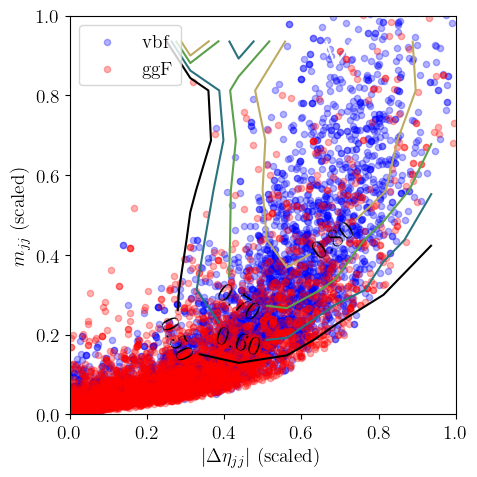

In [8]:
N = 4000
plot_data(sig[:N], bkg[:N], H=H,
          filename='higgs_vbf_ggf_data_based_contours_FNN.png')

### Prepare data
Convert data to PyTorch tensors, and send to computational device.

In [9]:
def dataframe2tensor(df, target, source):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device.
    x = torch.tensor(df[source].to_numpy()).float().to(device)
    t = torch.tensor(df[target].to_numpy()).int().to(device)
    return (x, t)

train_x, train_t = dataframe2tensor(train, target, features)
valid_x, valid_t = dataframe2tensor(valid, target, features)
test_x,  test_t  = dataframe2tensor(test,  target, features)

train_x[:5], train_t[:5]

(tensor([[0.1000, 0.0324],
         [0.4776, 0.1479],
         [0.0108, 0.0837],
         [0.8929, 0.9865],
         [0.1014, 0.0450]]),
 tensor([0, 1, 0, 1, 0], dtype=torch.int32))

### Empirical risk (that is, average loss)

The empirical risk, which is the __cost function__ we shall minimize, is defined by

\begin{align}
R_N(\theta) & = \frac{1}{N}\sum_{i=1}^N L(t_i, f_i),
\end{align}

where 

\begin{align*}
    f_i & \equiv f(\boldsymbol{x}_i, \boldsymbol{\omega})
\end{align*}

is the model, with parameters $\boldsymbol{\omega}$, to be fitted (i.e., trained). (In practice, for computational reasons, the fitting is done with __batches__ of data of size $n \ll N$ drawn from the training set of size $N$ with the batches changed every at every step of the minimization of the average loss.)

As noted in the Introduction, the empirical risk $R_N$ approximates the __risk functional__

\begin{align}
R[f] & = \int \int \,  L(t, f) \, p(t, \boldsymbol{x}) \, dt \, d\boldsymbol{x} .
\end{align}

The quantity $p(t, \boldsymbol{x}) \, dt\, d\boldsymbol{x}$ is the probability distribution associated with the training sample $\{ (t_i, \boldsymbol{x}_i), i = 1,\cdots, N \}$. 

### Empirical risk minimization (aka, minimizing the average loss)
Noting that $p(t | \boldsymbol{x}) = p(t, \boldsymbol{x}) / p(\boldsymbol{x})$ provided that $p(\boldsymbol{x}) > 0, \,\, \forall \,\, \boldsymbol{x}$, we can rewrite $R[f]$ as
\begin{align}
R[f] & = \int d\boldsymbol{x} \, p(\boldsymbol{x}) \left[\int \, L(t, f) \, p(t | \boldsymbol{x}) \, dt \right].
\end{align}
If the model $f$ has sufficient capacity, and we can switch the order of differentiation and integration, then it will be possible to set
\begin{align}
    \frac{\delta R}{\delta f} & = 0, \quad \forall \, \, \boldsymbol{x},
\end{align}
and arrive at the equation

$$\boxed{\,\,
\int \, \frac{\partial L(t, f)}{\partial f} \, p(t | \boldsymbol{x}) \, dt = 0}.$$

The above is a very important result because it determines the mathematical quantity that is being approximated by the fitted model, $\hat{f}(x) \equiv f(\boldsymbol{x}, \hat{\boldsymbol{\omega}})$. Moreover, the result confirms that the quantity approximated by the model is independent of its details. It does not matter whether the model is a lowly fully-connected neural network (FNN), such as the one in this tutorial, or a state-of-the-art transformer neural network (TNN). If both are trained with the same data and the same loss function both will approximate the same quantity. The difference is that the state-of-the-art model will yield an approximation that is superior to the one provided by the lowly model.

The necessary and sufficient conditions for arriving at this conclusion is that: 1) $f$ has sufficient __capacity__, that is, the parameter space of $f$ contains at least one point corresponding to a solution that is arbitrarily close to the true (but unknown) function that is being approximated; 2) the fit has been made with sufficient data, and 3) the minimizer is able to find a good approximation to the global minimum of the average loss.


#### Quadratic loss
For the __quadratic loss__ $L(t, f) = (t - f)^2$, the solution to the boxed equation above is 

$$ f^* = \int t \, p(t | \boldsymbol{x} ) \, dt ,$$

that is, the mean of the conditional probability $p(t | \boldsymbol{x} ) \, dt$. If the targets are discrete, for example, $t \in \{0, 1\}$, then

\begin{align}
    f^* & = p(t=1| \boldsymbol{x}) = \frac{p(\boldsymbol{x}|t=1) \, \epsilon}
    {p(\boldsymbol{x}|t=1) \, \epsilon + p(\boldsymbol{x}|t=0)},
\end{align}

that is, $f^*$ is equal to the probability that an object belongs to the class labeled by $t = 1$ given that the object is characterized by the __feature vector__ $\boldsymbol{x}$, where $\epsilon = p(t=1) \, / \, p(t=0)$ is the relative proportion of the two classes of objects in the sample used to fit the model $f$. For a __balanced__ data set $\epsilon = 1$.


The quadratic loss is typically used in regression problems, but as noted above, it can also be used to construct classifiers. However, because of its sensitivity to outliers it is more common to use the cross-entropy loss for classification problems.


#### Binary cross-entropy loss
The binary (i.e., 2-class) cross-entropy loss is defined by 

$$L(t, f) = - [t \log f + (1 - t) \log(1-f)],$$ 

with the discrete targets $t \in \{0, 1\}$. From

\begin{align*}
0 & = \int \, \frac{\partial L(t, f)}{\partial f} \, p(t | \boldsymbol{x}) \, dt, \quad \text{ we see that}\\
    & = \int \,  \left( \frac{t}{f} - \frac{(1 - t)}{1-f}  \right) p(t | \boldsymbol{x}) \, dt,\\
    & = \frac{p(t=1 | \boldsymbol{x})}{f} - \frac{p(t=0 | \boldsymbol{x})}{1 -f},\\
   \frac{f}{1-f} & = \frac{p(t=1 | \boldsymbol{x})}{p(t=0 | \boldsymbol{x})},\quad \implies f  = p(t=1 | \boldsymbol{x}) .
\end{align*}

Again, we stress that this conclusion is independent of the details of the model $f(\boldsymbol{x}, \boldsymbol{\omega})$.

### Average Loss Functions 
Several standard average loss functions are available 
in PyTorch, such as __nn.CrossEntropyLoss()__. But it's useful 
to know how to create your own.

In [10]:
def average_quadratic_loss(f, t):
    # f and t must be of the same shape
    losses = (f - t)**2
    return torch.mean(losses)

def average_cross_entropy_loss(f, t):
    # f and t must be of the same shape
    # Note: because of our use of the "where" function, the 
    # precise values of the targets doesn't matter so long as for
    # one class t < 0.5 and the other t > 0.5
    losses = -torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return torch.mean(losses)

### Return a batch of data from the training set

In [11]:
def get_batch(x, t, batch_size, n):
    i = n * batch_size # first row
    j = i + batch_size # last row + 1 # a Python oddity!
    return x[i:j], t[i:j]

def get_random_batch(x, t, batch_size, n=None):
    indices = rd.choices(range(len(x)), k=batch_size)
    indices.sort()
    #indices = np.random.choice(len(x), batch_size)
    return x[indices], t[indices]

This function is used to validate the model while it is being fitted.

In [12]:
def validate(model, avloss, x, t):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        # reshape to ensure that y and t are of the same shape!
        y = model(x).reshape(t.shape)
    return avloss(y, t)

### Function to execute one epoch of the training loop

In [13]:
def train_model(epoch, 
                model, optimizer, averageloss, getbatch,
                train_x, train_t, 
                valid_x, valid_t,
                batch_size,
                number_iterations,
                losses, 
                best_model_file='bestmodel.pt',
                step=10):
    import copy
    
    # to keep track of average losses
    xx, yy_t, yy_v = losses

    n = len(valid_x)
    
    if epoch < 1:
        print("%5s %10s\t%10s\t%10s" % \
              ('epoch', 'iteration', 'training', 'validation'))

    # start saving best model after the
    # following number of iterations.
    start_saving = number_iterations // 100
    min_avloss   = float('inf')
    saved        = ''
    
    for ii in range(number_iterations):
        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
    
        # get a batch of data 
        x, t = getbatch(train_x, train_t, batch_size, ii)     

        # compute the output of the model for the batch of data x
        # Note: y (the output of the model) is 
        #   of shape (-1, 1), but the target tensor, t, is
        #   of shape (-1,)
        # In order for the tensor operations with y and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        y = model(x).reshape(t.shape)
   
        # compute a noisy approximation of the average loss.
        # Adding a bit of noise helps the minimizer escape
        # from minima that may not optimal. It is also much
        # faster to compute the loss function and its gradient
        # with respect to its parameters using batches of 
        # training data rather than the full training dataset.
        empirical_risk = averageloss(y, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            avloss_t = validate(model, averageloss, 
                                train_x[:n], train_t[:n])
            
            avloss_v = validate(model, averageloss, 
                                valid_x, valid_t)

            if len(xx) < 1:
                xx.append(0)
                print("%5d %10d\t%10.6f\t%10.6f %s" % \
                      (epoch, xx[-1], avloss_t, avloss_v, saved))
            else:
                xx.append(xx[-1] + step)
                print("\r%5d %10d\t%10.6f\t%10.6f %s" % \
                      (epoch, xx[-1], avloss_t, avloss_v, saved), 
                      end='')
                
            yy_t.append(avloss_t)
            yy_v.append(avloss_v)
            
            if avloss_v < min_avloss:
                min_avloss = avloss_v
                
                if ii > start_saving:
                    saved = str(ii)
                    torch.save(model.state_dict(), best_model_file)

    torch.save(model.state_dict(), 'finalmodel.pt')
    print() 
    
    return xx, yy_t, yy_v

In [14]:
def plot_average_losses(losses):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.legend()
    
    ax.set_xlabel('iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')

    fig.tight_layout()
    plt.show()

### Define model $f(\boldsymbol{x}, \boldsymbol{\omega})$

$$f(\boldsymbol{x}, \boldsymbol{\omega}) = \text{sigmoid}(\, b_3 + \boldsymbol{w}_3\text{relu}(\, \boldsymbol{b}_2 + \boldsymbol{w}_2 \, \text{relu}(\,\boldsymbol{b}_1 + \boldsymbol{w}_1 \, \text{relu}(\boldsymbol{b}_0 + \boldsymbol{w}_0 \, \boldsymbol{x}) \, )\,)\,)$$

In [15]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
class Model(nn.Module):
    
    def __init__(self, n_inputs=2, n_nodes=25, n_layers=3):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y

model = Model().to(device)

print(model)
print('number of parameters: %d' % number_of_parameters(model))

Model(
  (layer0): Linear(in_features=2, out_features=25, bias=True)
  (layer1): Linear(in_features=25, out_features=25, bias=True)
  (layer2): Linear(in_features=25, out_features=25, bias=True)
  (layer3): Linear(in_features=25, out_features=1, bias=True)
)
number of parameters: 1401


### Train!
Instantiate an optimizer, then train

In [17]:
learning_rate = 5.e-4
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

average_loss  = average_cross_entropy_loss

step          = 10
losses        = ([], [], [])

epoch  iteration	  training	validation
    0          0	  0.697962	  0.697801 
    0      99990	  0.588238	  0.580323 70760


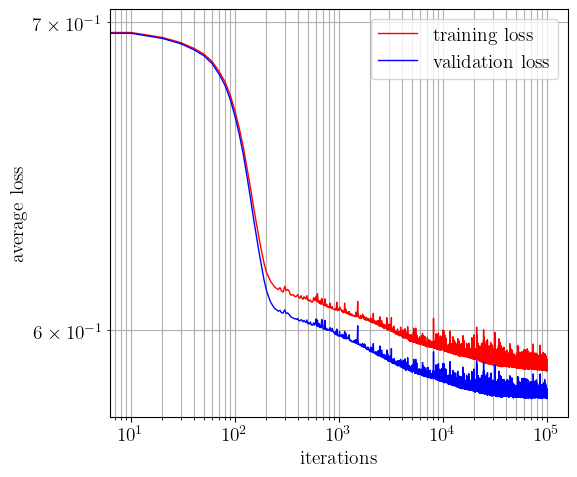

In [18]:
nepochs    = 1      # number of times through dataset
niterations= 100000
batch_size = 128    # sample over which to compute average loss
best_model_file = 'hzz4l_model.pt'

for epoch in range(nepochs):
    
    losses = train_model(epoch, 
                         model, optimizer, average_loss, 
                         get_random_batch,
                         train_x, train_t, 
                         valid_x, valid_t,
                         batch_size, niterations,
                         losses, 
                         best_model_file, 
                         step)

plot_average_losses(losses)

### Plot contours of $p(\textrm{vbf} | x)$

In [19]:
def compute(dnn, x):
    # go to evaluation mode
    dnn.eval()
    # 1. convert to a tensor
    # 2. compute
    # 3. reshape to a 1D tensor
    # 4. detach from computation tree and convert to a numpy array
    x = torch.Tensor(x)
    y = dnn(x).view(-1,).detach().numpy()
    return y


# load best model to computational device
model.load_state_dict(torch.load(best_model_file, 
                                 map_location=torch.device(device)))

test_y = compute(model, test_x)

In [20]:
def compute_dnn_contours(dnn,                  
                 xmin=XMIN, xmax=XMAX, 
                 ymin=YMIN, ymax=YMAX):
    
    # 1. first create a mesh
    # 2. compute network output at all mesh points
    npoints= 50
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    xx     = np.arange(xmin+xdelta/2, xmax, xdelta)
    yy     = np.arange(ymin+ydelta/2, ymax, ydelta)
    X, Y   = np.meshgrid(xx, yy)
    
    # convert mesh a list of lists
    XY     = list(zip(X.flatten(), Y.flatten()))
    
    # compute model output at every grid point
    # then reshape to an (npoints x npoints) array
    Z = compute(dnn, XY).reshape([npoints, npoints])
    return (X, Y, Z)

In [21]:
dnn_H = compute_dnn_contours(model)

As we explained in the section on empirical risk, the cross-entropy loss yields a model that approximates the probability $p(\textrm{vbf}| \mathbf{x})$, which is displayed below as contours of fixed probability.

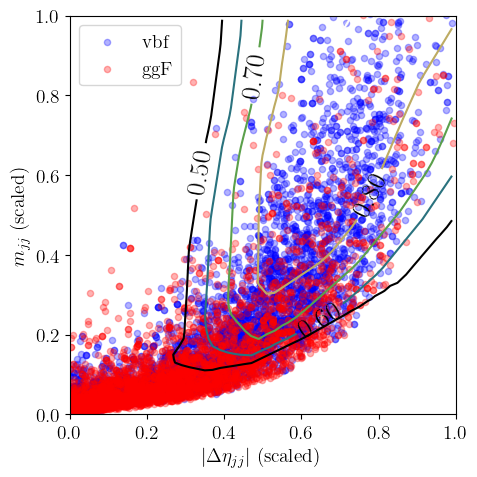

In [22]:
plot_data(sig[:N], bkg[:N], H=dnn_H, 
          filename='higgs_vbf_ggf_dnn_contours.png')

### Plot distribution of $p(\textrm{vbf}| \mathbf{x})$ for vbf and ggf

In [23]:
def plot_distribution(y, t, 
                      nbins=50, 
                      ftsize=FONTSIZE, 
                      fgsize=(7, 5)):

    # select the model output results for VBF events
    vbf = y[t > 0.5]
    
    # select the model output results for ggF events
    ggf = y[t < 0.5]
    
    # set size of figure
    plt.figure(figsize=fgsize)
    
    plt.xlim(0, 1)
    plt.ylim(0, 5)
    
    plt.hist(ggf, 
             bins=nbins, 
             color=(1,0,0),
             alpha=0.3,
             range=(0,1), 
             density=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (ggf)') 
    plt.legend(fontsize='small')
    
    plt.hist(vbf, 
             bins=nbins, 
             color=(0,1,0),
             alpha=0.3,
             range=(0,1), 
             density=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (vbf)')
    plt.legend(fontsize='small')

    plt.savefig("hzz_distributions_FNN.png")
    plt.show()

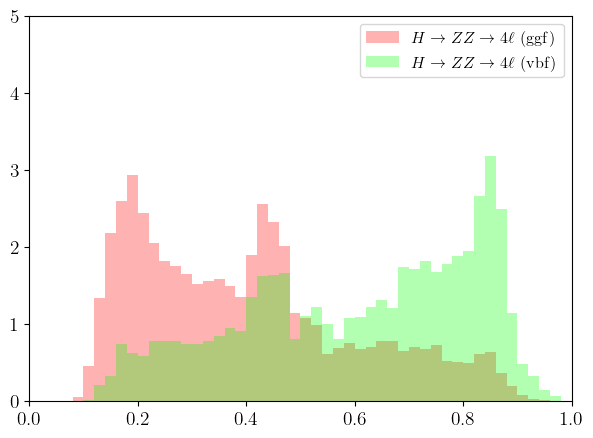

In [24]:
plot_distribution(test_y, test_t)

### Plot Receiver Operating Characteristic (ROC) curve
The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) was developed in the context of radar operations during World War II. It is a simple measure of the performance of a binary classifier. Recall the definition of the __right cumulative distribution function__

$$D_R(y) = \mathbb{P}(y > y_0).$$

When applied to the histograms above, $D_R(y)$ gives the fraction of events that remain when they are selected by applying the cut $y > y_0$ on the output $y$ of the classifier. The ROC curve is a plot of $D_R(y)$ for one class of objects versus $D_R(y)$ for the other class for different thresholds $y_0$. Another simple measure of performance, this time a global one, is the area under the ROC curve (AUC). 

If the histograms were identical the ROC curve would be a diagonal line of unit slope (see blue-dashed curve below) and the AOC would be 0.5. Borrowing some jargon from statistics, a classifier whose ROC curve dips below the diagonal line could justifiably be called *inadmissible*!

In [25]:
def plot_ROC(y, p):
    
    bad, good, _ = roc_curve(y, p)
    
    roc_auc = auc(bad, good)
    plt.figure(figsize=(5, 5))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('fraction of ggF events', fontsize=14)
    plt.ylabel('fraction of vbf events', fontsize=14)
    
    plt.plot(bad, good, color='red',
             lw=2, label='ROC curve, AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

    plt.legend(loc="lower right", fontsize=14)
    
    plt.savefig("hzz_ROC.png")
    plt.show()

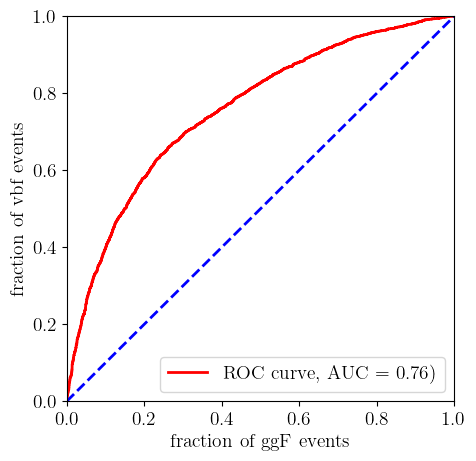

In [26]:
plot_ROC(test_t, test_y)